In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:

def round_down(val, amt):
    return amt*math.floor(val/amt)

def round_up(val, amt):
    return amt*math.ceil(val/amt)

def intervals(xmin,xmax,spacing):
    return [xmin + spacing*i for i in range(int((xmax-xmin)/spacing)+1)]

def make_hist(a, bin_length):
    a_min = np.min(a)
    a_max = np.max(a)
    # round down bin length
    hist, edges = np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length))
    return hist, edges

def make_hist_from_std_dev(a,factor):
    s = np.std(a)
    bin_length = factor*s
    return make_hist(a, bin_length)

def make_hists(arrs, bin_length):
    a_min = np.min(arrs)
    a_max = np.max(arrs)
    # round down bin length
    li = [np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length)) for a in arrs]
    edges = li[0][1]
    hists = [t[0] for t in li] 
    return hists, edges

def make_hists_from_std_dev(arrs, factor):
    s = np.std(arrs[0])
    bin_length = factor*s
    return make_hists(arrs, bin_length)

def tv(a1,a2):
    return np.sum(np.abs((a1-a2).astype(float)))/(2*np.sum(a1))

#first array is ground truth
def merr(arrs, factor,verbosity=1):
    (num_arrs, sample_size, d) = arrs.shape
    tvs = np.zeros((num_arrs-1, d))
    hists_list = []
    for i in range(d):
        arr_i = arrs[:,:,i]
        hists, edges = make_hists_from_std_dev(arr_i, factor)
        printv(hists, verbosity,1)
        hists_list += [hists]
        for j in range(num_arrs-1):
            tvs[j,i] = tv(hists[0], hists[j+1])
    merrs = np.sum(tvs, axis=1)/d
    return tvs, merrs, hists
#def ma(true_samples, samples, side_length):

In [3]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets
def redraw_samples(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):
def redraw_samples_for_agents(agents, num, verbosity=1):
    samples_list = []

    for agent in agents:
        samples = redraw_samples(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [4]:
num_articles = 1
dim = 1
var = 1.0
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=0

In [5]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)
make_prec_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity, precondition='proper', weights=True)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

SEED: 1
theta [1.62434536]
Experiment: Step 0
 Cum regret: 0.000000
 Cum regret: 0.000000
 Cum regret: 0.000000
 Cum regret: 0.000000
 Cum regret: 0.000000
 Cum regret: 0.000000


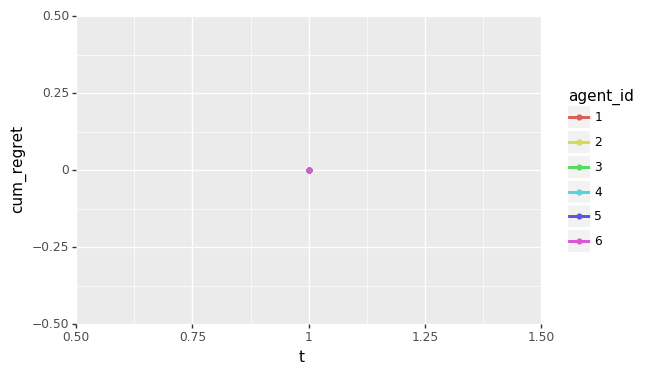

<ggplot: (8743589069713)>


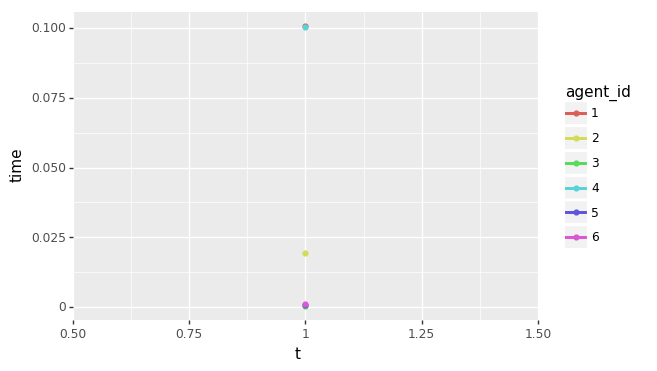

<ggplot: (8743808000221)>


([   action_id agent_id  cum_optimal  cum_regret  instant_regret  steps_taken  \
  0          1        1     0.933299         0.0             0.0          281   
  1          2        2     0.933299         0.0             0.0            0   
  2          3        3     0.933299         0.0             0.0            0   
  3          4        4     0.933299         0.0             0.0         1133   
  4          5        5     0.933299         0.0             0.0            0   
  5          6        6     0.933299         0.0             0.0            0   
  
     t      time unique_id  
  0  1  0.100804      NULL  
  1  1  0.019498      NULL  
  2  1  0.000358      NULL  
  3  1  0.100512      NULL  
  4  1  0.000727      NULL  
  5  1  0.001049      NULL  ],
    action_id agent_id  cum_optimal  cum_regret  instant_regret  steps_taken  \
 0          1        1     0.933299         0.0             0.0          281   
 1          2        2     0.933299         0.0             0.0  

In [6]:
agents = [make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent(),
          make_prec_sagald_agent()]
simple_compare(agents, num_articles, dim, var, 1, 1, verbosity=1)

In [7]:
samples_list = []
agents[0].v=1
agents[0].time=0
agents[0].n_steps=500
for agent in agents:
    samples = redraw_samples(agent, 1000, 2)
    samples_list += [samples]
samples_list = np.asarray(samples_list)

Drawing sample 1
 Accept proportion: 0.930000
 Steps taken: 500
 array([0.08374069])
Drawing sample 2
 Accept proportion: 0.932000
 Steps taken: 500
 array([0.3519997])
Drawing sample 3
 Accept proportion: 0.930000
 Steps taken: 500
 array([0.35362077])
Drawing sample 4
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.62055183])
Drawing sample 5
 Accept proportion: 0.940000
 Steps taken: 500
 array([-0.1292327])
Drawing sample 6
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.48225527])
Drawing sample 7
 Accept proportion: 0.932000
 Steps taken: 500
 array([1.05835397])
Drawing sample 8
 Accept proportion: 0.936000
 Steps taken: 500
 array([1.02308478])
Drawing sample 9
 Accept proportion: 0.952000
 Steps taken: 500
 array([1.14651529])
Drawing sample 10
 Accept proportion: 0.930000
 Steps taken: 500
 array([0.74038968])
Drawing sample 11
 Accept proportion: 0.942000
 Steps taken: 500
 array([1.01990583])
Drawing sample 12
 Accept proportion: 0.926000
 Steps taken: 500

 Accept proportion: 0.920000
 Steps taken: 500
 array([1.44840003])
Drawing sample 97
 Accept proportion: 0.916000
 Steps taken: 500
 array([-0.25239278])
Drawing sample 98
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.67538063])
Drawing sample 99
 Accept proportion: 0.944000
 Steps taken: 500
 array([0.68379212])
Drawing sample 100
 Accept proportion: 0.916000
 Steps taken: 500
 array([0.29883066])
Drawing sample 101
 Accept proportion: 0.922000
 Steps taken: 500
 array([0.75002158])
Drawing sample 102
 Accept proportion: 0.918000
 Steps taken: 500
 array([1.51465397])
Drawing sample 103
 Accept proportion: 0.930000
 Steps taken: 500
 array([1.82514531])
Drawing sample 104
 Accept proportion: 0.930000
 Steps taken: 500
 array([1.53511946])
Drawing sample 105
 Accept proportion: 0.958000
 Steps taken: 500
 array([0.82911082])
Drawing sample 106
 Accept proportion: 0.946000
 Steps taken: 500
 array([-0.27874647])
Drawing sample 107
 Accept proportion: 0.948000
 Steps taken: 5

 Accept proportion: 0.948000
 Steps taken: 500
 array([-0.78214408])
Drawing sample 191
 Accept proportion: 0.938000
 Steps taken: 500
 array([-0.53077254])
Drawing sample 192
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.5849605])
Drawing sample 193
 Accept proportion: 0.950000
 Steps taken: 500
 array([-0.3967347])
Drawing sample 194
 Accept proportion: 0.916000
 Steps taken: 500
 array([0.14010807])
Drawing sample 195
 Accept proportion: 0.948000
 Steps taken: 500
 array([0.70207369])
Drawing sample 196
 Accept proportion: 0.928000
 Steps taken: 500
 array([1.26318544])
Drawing sample 197
 Accept proportion: 0.946000
 Steps taken: 500
 array([0.60160214])
Drawing sample 198
 Accept proportion: 0.956000
 Steps taken: 500
 array([0.00576208])
Drawing sample 199
 Accept proportion: 0.944000
 Steps taken: 500
 array([0.8199974])
Drawing sample 200
 Accept proportion: 0.946000
 Steps taken: 500
 array([0.02518933])
Drawing sample 201
 Accept proportion: 0.920000
 Steps taken: 

 Accept proportion: 0.946000
 Steps taken: 500
 array([1.16090431])
Drawing sample 286
 Accept proportion: 0.950000
 Steps taken: 500
 array([0.24277945])
Drawing sample 287
 Accept proportion: 0.944000
 Steps taken: 500
 array([0.03795207])
Drawing sample 288
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.25209573])
Drawing sample 289
 Accept proportion: 0.930000
 Steps taken: 500
 array([2.03001969])
Drawing sample 290
 Accept proportion: 0.944000
 Steps taken: 500
 array([1.73771168])
Drawing sample 291
 Accept proportion: 0.934000
 Steps taken: 500
 array([0.34789711])
Drawing sample 292
 Accept proportion: 0.950000
 Steps taken: 500
 array([0.13843392])
Drawing sample 293
 Accept proportion: 0.956000
 Steps taken: 500
 array([0.24437842])
Drawing sample 294
 Accept proportion: 0.938000
 Steps taken: 500
 array([0.02398346])
Drawing sample 295
 Accept proportion: 0.934000
 Steps taken: 500
 array([0.36275485])
Drawing sample 296
 Accept proportion: 0.948000
 Steps taken: 

 Accept proportion: 0.936000
 Steps taken: 500
 array([0.83992248])
Drawing sample 381
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.17046842])
Drawing sample 382
 Accept proportion: 0.934000
 Steps taken: 500
 array([0.13009694])
Drawing sample 383
 Accept proportion: 0.934000
 Steps taken: 500
 array([1.10832675])
Drawing sample 384
 Accept proportion: 0.924000
 Steps taken: 500
 array([0.04752305])
Drawing sample 385
 Accept proportion: 0.928000
 Steps taken: 500
 array([1.67819157])
Drawing sample 386
 Accept proportion: 0.934000
 Steps taken: 500
 array([-0.45039028])
Drawing sample 387
 Accept proportion: 0.938000
 Steps taken: 500
 array([1.27111871])
Drawing sample 388
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.14294968])
Drawing sample 389
 Accept proportion: 0.944000
 Steps taken: 500
 array([-1.22953332])
Drawing sample 390
 Accept proportion: 0.934000
 Steps taken: 500
 array([0.33894274])
Drawing sample 391
 Accept proportion: 0.928000
 Steps taken

 Accept proportion: 0.936000
 Steps taken: 500
 array([0.3075636])
Drawing sample 476
 Accept proportion: 0.936000
 Steps taken: 500
 array([0.34376268])
Drawing sample 477
 Accept proportion: 0.938000
 Steps taken: 500
 array([0.14559219])
Drawing sample 478
 Accept proportion: 0.944000
 Steps taken: 500
 array([0.85926324])
Drawing sample 479
 Accept proportion: 0.946000
 Steps taken: 500
 array([-0.84179828])
Drawing sample 480
 Accept proportion: 0.946000
 Steps taken: 500
 array([0.03989398])
Drawing sample 481
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.02322405])
Drawing sample 482
 Accept proportion: 0.936000
 Steps taken: 500
 array([1.49247332])
Drawing sample 483
 Accept proportion: 0.940000
 Steps taken: 500
 array([0.34803854])
Drawing sample 484
 Accept proportion: 0.936000
 Steps taken: 500
 array([1.23696724])
Drawing sample 485
 Accept proportion: 0.946000
 Steps taken: 500
 array([0.74044558])
Drawing sample 486
 Accept proportion: 0.946000
 Steps taken: 

 Accept proportion: 0.936000
 Steps taken: 500
 array([0.30573992])
Drawing sample 571
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.44629338])
Drawing sample 572
 Accept proportion: 0.940000
 Steps taken: 500
 array([0.25616957])
Drawing sample 573
 Accept proportion: 0.948000
 Steps taken: 500
 array([0.13850905])
Drawing sample 574
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.42712016])
Drawing sample 575
 Accept proportion: 0.942000
 Steps taken: 500
 array([1.41013])
Drawing sample 576
 Accept proportion: 0.942000
 Steps taken: 500
 array([1.78641368])
Drawing sample 577
 Accept proportion: 0.932000
 Steps taken: 500
 array([0.45038047])
Drawing sample 578
 Accept proportion: 0.932000
 Steps taken: 500
 array([0.26348351])
Drawing sample 579
 Accept proportion: 0.958000
 Steps taken: 500
 array([0.43992228])
Drawing sample 580
 Accept proportion: 0.926000
 Steps taken: 500
 array([-0.19868208])
Drawing sample 581
 Accept proportion: 0.928000
 Steps taken: 50

 Accept proportion: 0.928000
 Steps taken: 500
 array([0.80010007])
Drawing sample 667
 Accept proportion: 0.934000
 Steps taken: 500
 array([-0.69366951])
Drawing sample 668
 Accept proportion: 0.916000
 Steps taken: 500
 array([-0.00813069])
Drawing sample 669
 Accept proportion: 0.912000
 Steps taken: 500
 array([0.7175221])
Drawing sample 670
 Accept proportion: 0.916000
 Steps taken: 500
 array([-0.20994689])
Drawing sample 671
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.51743972])
Drawing sample 672
 Accept proportion: 0.954000
 Steps taken: 500
 array([0.39663197])
Drawing sample 673
 Accept proportion: 0.918000
 Steps taken: 500
 array([0.49623277])
Drawing sample 674
 Accept proportion: 0.946000
 Steps taken: 500
 array([0.0984672])
Drawing sample 675
 Accept proportion: 0.930000
 Steps taken: 500
 array([0.03516556])
Drawing sample 676
 Accept proportion: 0.938000
 Steps taken: 500
 array([0.95434254])
Drawing sample 677
 Accept proportion: 0.916000
 Steps taken:

 Accept proportion: 0.924000
 Steps taken: 500
 array([0.69518434])
Drawing sample 762
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.97917453])
Drawing sample 763
 Accept proportion: 0.948000
 Steps taken: 500
 array([-0.07896019])
Drawing sample 764
 Accept proportion: 0.964000
 Steps taken: 500
 array([-0.78010791])
Drawing sample 765
 Accept proportion: 0.938000
 Steps taken: 500
 array([1.46134203])
Drawing sample 766
 Accept proportion: 0.948000
 Steps taken: 500
 array([-0.55831021])
Drawing sample 767
 Accept proportion: 0.950000
 Steps taken: 500
 array([0.3071021])
Drawing sample 768
 Accept proportion: 0.932000
 Steps taken: 500
 array([0.00788399])
Drawing sample 769
 Accept proportion: 0.944000
 Steps taken: 500
 array([1.38807295])
Drawing sample 770
 Accept proportion: 0.934000
 Steps taken: 500
 array([1.62745622])
Drawing sample 771
 Accept proportion: 0.940000
 Steps taken: 500
 array([0.29240535])
Drawing sample 772
 Accept proportion: 0.922000
 Steps taken

 Accept proportion: 0.926000
 Steps taken: 500
 array([1.07074836])
Drawing sample 857
 Accept proportion: 0.932000
 Steps taken: 500
 array([1.44194432])
Drawing sample 858
 Accept proportion: 0.918000
 Steps taken: 500
 array([0.43132129])
Drawing sample 859
 Accept proportion: 0.948000
 Steps taken: 500
 array([0.77059873])
Drawing sample 860
 Accept proportion: 0.954000
 Steps taken: 500
 array([0.05860792])
Drawing sample 861
 Accept proportion: 0.934000
 Steps taken: 500
 array([1.49459803])
Drawing sample 862
 Accept proportion: 0.948000
 Steps taken: 500
 array([0.61354623])
Drawing sample 863
 Accept proportion: 0.934000
 Steps taken: 500
 array([1.35153581])
Drawing sample 864
 Accept proportion: 0.928000
 Steps taken: 500
 array([0.05850379])
Drawing sample 865
 Accept proportion: 0.948000
 Steps taken: 500
 array([0.04544223])
Drawing sample 866
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.35275405])
Drawing sample 867
 Accept proportion: 0.936000
 Steps taken: 

 Accept proportion: 0.932000
 Steps taken: 500
 array([-0.73984589])
Drawing sample 953
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.21460657])
Drawing sample 954
 Accept proportion: 0.942000
 Steps taken: 500
 array([1.11367677])
Drawing sample 955
 Accept proportion: 0.928000
 Steps taken: 500
 array([1.7537181])
Drawing sample 956
 Accept proportion: 0.928000
 Steps taken: 500
 array([0.69290889])
Drawing sample 957
 Accept proportion: 0.952000
 Steps taken: 500
 array([0.80496269])
Drawing sample 958
 Accept proportion: 0.940000
 Steps taken: 500
 array([0.21086173])
Drawing sample 959
 Accept proportion: 0.942000
 Steps taken: 500
 array([0.71156016])
Drawing sample 960
 Accept proportion: 0.936000
 Steps taken: 500
 array([0.61189294])
Drawing sample 961
 Accept proportion: 0.934000
 Steps taken: 500
 array([1.1712968])
Drawing sample 962
 Accept proportion: 0.926000
 Steps taken: 500
 array([-0.33960514])
Drawing sample 963
 Accept proportion: 0.938000
 Steps taken: 

Drawing sample 316
 array([3.38823609])
Drawing sample 317
 array([3.81030488])
Drawing sample 318
 array([1.97494847])
Drawing sample 319
 array([2.24268825])
Drawing sample 320
 array([3.32193473])
Drawing sample 321
 array([2.26649581])
Drawing sample 322
 array([1.82980576])
Drawing sample 323
 array([2.59549488])
Drawing sample 324
 array([4.03265217])
Drawing sample 325
 array([3.51475511])
Drawing sample 326
 array([2.13959618])
Drawing sample 327
 array([2.75593846])
Drawing sample 328
 array([1.53583614])
Drawing sample 329
 array([2.09791485])
Drawing sample 330
 array([2.31296243])
Drawing sample 331
 array([2.69936838])
Drawing sample 332
 array([3.27042321])
Drawing sample 333
 array([2.59754622])
Drawing sample 334
 array([2.0796504])
Drawing sample 335
 array([3.5877166])
Drawing sample 336
 array([1.86781607])
Drawing sample 337
 array([3.5364918])
Drawing sample 338
 array([1.19969355])
Drawing sample 339
 array([2.46032452])
Drawing sample 340
 array([3.40664852])
Dra

 array([2.95064845])
Drawing sample 594
 array([3.42780619])
Drawing sample 595
 array([2.60430147])
Drawing sample 596
 array([3.72775256])
Drawing sample 597
 array([2.42499012])
Drawing sample 598
 array([2.62276644])
Drawing sample 599
 array([3.53256054])
Drawing sample 600
 array([3.33338179])
Drawing sample 601
 array([2.5354178])
Drawing sample 602
 array([2.49389012])
Drawing sample 603
 array([2.54644087])
Drawing sample 604
 array([3.87537828])
Drawing sample 605
 array([2.0605687])
Drawing sample 606
 array([2.91749488])
Drawing sample 607
 array([3.6928695])
Drawing sample 608
 array([3.81104931])
Drawing sample 609
 array([2.68855372])
Drawing sample 610
 array([2.94022455])
Drawing sample 611
 array([2.76636624])
Drawing sample 612
 array([3.34433223])
Drawing sample 613
 array([3.20178518])
Drawing sample 614
 array([3.94658028])
Drawing sample 615
 array([2.44554369])
Drawing sample 616
 array([1.87028351])
Drawing sample 617
 array([2.89580027])
Drawing sample 618
 ar

 array([1.00142922])
Drawing sample 856
 array([3.10666096])
Drawing sample 857
 array([3.76483214])
Drawing sample 858
 array([3.75197479])
Drawing sample 859
 array([4.34066575])
Drawing sample 860
 array([2.42131868])
Drawing sample 861
 array([4.5608312])
Drawing sample 862
 array([4.39175535])
Drawing sample 863
 array([2.45104353])
Drawing sample 864
 array([2.72869638])
Drawing sample 865
 array([4.43361975])
Drawing sample 866
 array([3.20778659])
Drawing sample 867
 array([4.00226231])
Drawing sample 868
 array([4.77709613])
Drawing sample 869
 array([3.08566443])
Drawing sample 870
 array([3.71490321])
Drawing sample 871
 array([3.47828137])
Drawing sample 872
 array([3.81514801])
Drawing sample 873
 array([2.81615216])
Drawing sample 874
 array([4.20681293])
Drawing sample 875
 array([2.75829549])
Drawing sample 876
 array([3.40398722])
Drawing sample 877
 array([2.51916967])
Drawing sample 878
 array([3.21379937])
Drawing sample 879
 array([3.16095903])
Drawing sample 880
 

 array([0.68994665])
Drawing sample 64
 array([0.50775012])
Drawing sample 65
 array([0.47998923])
Drawing sample 66
 array([0.94003691])
Drawing sample 67
 array([-0.25988566])
Drawing sample 68
 array([-0.18109438])
Drawing sample 69
 array([-0.25702025])
Drawing sample 70
 array([0.34610403])
Drawing sample 71
 array([-0.57336406])
Drawing sample 72
 array([-0.39409098])
Drawing sample 73
 array([1.21137199])
Drawing sample 74
 array([-1.03022534])
Drawing sample 75
 array([0.31219583])
Drawing sample 76
 array([-0.07972432])
Drawing sample 77
 array([-0.26133527])
Drawing sample 78
 array([1.14391635])
Drawing sample 79
 array([0.07151611])
Drawing sample 80
 array([-0.13903557])
Drawing sample 81
 array([0.3553854])
Drawing sample 82
 array([-0.67120928])
Drawing sample 83
 array([-0.11299868])
Drawing sample 84
 array([1.24756648])
Drawing sample 85
 array([-0.78454707])
Drawing sample 86
 array([0.73639472])
Drawing sample 87
 array([0.52178487])
Drawing sample 88
 array([-0.191

 array([0.7541744])
Drawing sample 270
 array([0.77002194])
Drawing sample 271
 array([-0.07972184])
Drawing sample 272
 array([1.27772427])
Drawing sample 273
 array([0.2326405])
Drawing sample 274
 array([1.27449117])
Drawing sample 275
 array([0.07825837])
Drawing sample 276
 array([0.65873277])
Drawing sample 277
 array([-1.2262386])
Drawing sample 278
 array([0.2661991])
Drawing sample 279
 array([1.58560635])
Drawing sample 280
 array([-0.64525247])
Drawing sample 281
 array([0.79829972])
Drawing sample 282
 array([-1.01359866])
Drawing sample 283
 array([-1.093289])
Drawing sample 284
 array([-0.73936388])
Drawing sample 285
 array([1.54518835])
Drawing sample 286
 array([0.86080255])
Drawing sample 287
 array([0.54724729])
Drawing sample 288
 array([-0.19011618])
Drawing sample 289
 array([1.04278262])
Drawing sample 290
 array([0.70228191])
Drawing sample 291
 array([1.61581495])
Drawing sample 292
 array([0.55820799])
Drawing sample 293
 array([2.33019075])
Drawing sample 294

 array([-0.21692215])
Drawing sample 475
 array([-0.43945968])
Drawing sample 476
 array([-0.57054055])
Drawing sample 477
 array([0.12955049])
Drawing sample 478
 array([-0.07387972])
Drawing sample 479
 array([1.91937264])
Drawing sample 480
 array([-0.10669474])
Drawing sample 481
 array([-0.37909617])
Drawing sample 482
 array([1.57608478])
Drawing sample 483
 array([-0.12148147])
Drawing sample 484
 array([0.44235917])
Drawing sample 485
 array([1.0341332])
Drawing sample 486
 array([0.84680413])
Drawing sample 487
 array([-0.75269906])
Drawing sample 488
 array([0.26516521])
Drawing sample 489
 array([0.48156929])
Drawing sample 490
 array([-0.95285664])
Drawing sample 491
 array([-0.90730564])
Drawing sample 492
 array([-0.67031649])
Drawing sample 493
 array([-0.26323365])
Drawing sample 494
 array([1.33016952])
Drawing sample 495
 array([0.50732021])
Drawing sample 496
 array([0.5168926])
Drawing sample 497
 array([0.19376367])
Drawing sample 498
 array([0.48613705])
Drawing s

 array([0.39436274])
Drawing sample 679
 array([-0.40107483])
Drawing sample 680
 array([0.46875984])
Drawing sample 681
 array([0.40217852])
Drawing sample 682
 array([-0.59234359])
Drawing sample 683
 array([1.85663485])
Drawing sample 684
 array([0.56417371])
Drawing sample 685
 array([0.32111987])
Drawing sample 686
 array([-0.98247656])
Drawing sample 687
 array([0.81066753])
Drawing sample 688
 array([-0.8590824])
Drawing sample 689
 array([0.73334753])
Drawing sample 690
 array([0.22439103])
Drawing sample 691
 array([1.59598592])
Drawing sample 692
 array([-0.62912501])
Drawing sample 693
 array([-0.56234725])
Drawing sample 694
 array([-0.31842174])
Drawing sample 695
 array([0.77789961])
Drawing sample 696
 array([0.75392449])
Drawing sample 697
 array([0.24906118])
Drawing sample 698
 array([0.36471755])
Drawing sample 699
 array([-0.15060683])
Drawing sample 700
 array([1.58391219])
Drawing sample 701
 array([-0.7316624])
Drawing sample 702
 array([-0.74095429])
Drawing sam

 array([1.26293698])
Drawing sample 883
 array([0.05524777])
Drawing sample 884
 array([-0.56658869])
Drawing sample 885
 array([0.13041828])
Drawing sample 886
 array([0.42714568])
Drawing sample 887
 array([1.241629])
Drawing sample 888
 array([-0.49678997])
Drawing sample 889
 array([0.01278117])
Drawing sample 890
 array([0.15834781])
Drawing sample 891
 array([0.49062579])
Drawing sample 892
 array([1.34145049])
Drawing sample 893
 array([-1.20611842])
Drawing sample 894
 array([1.58180326])
Drawing sample 895
 array([1.19954567])
Drawing sample 896
 array([-0.28404935])
Drawing sample 897
 array([0.27097978])
Drawing sample 898
 array([0.19952457])
Drawing sample 899
 array([1.7250801])
Drawing sample 900
 array([0.34288435])
Drawing sample 901
 array([0.7631124])
Drawing sample 902
 array([1.38413447])
Drawing sample 903
 array([-1.01029737])
Drawing sample 904
 array([-0.01401176])
Drawing sample 905
 array([0.14514194])
Drawing sample 906
 array([0.65467834])
Drawing sample 90

 array([-0.64120194])
Drawing sample 90
 array([1.19543851])
Drawing sample 91
 array([1.78300321])
Drawing sample 92
 array([0.03166368])
Drawing sample 93
 array([1.65677233])
Drawing sample 94
 array([0.733335])
Drawing sample 95
 array([0.27688632])
Drawing sample 96
 array([0.03950663])
Drawing sample 97
 array([-0.04319238])
Drawing sample 98
 array([1.17186213])
Drawing sample 99
 array([0.40322487])
Drawing sample 100
 array([-0.2207429])
Drawing sample 101
 array([1.24634175])
Drawing sample 102
 array([0.62193885])
Drawing sample 103
 array([1.4085088])
Drawing sample 104
 array([1.27475927])
Drawing sample 105
 array([0.53775519])
Drawing sample 106
 array([0.82545312])
Drawing sample 107
 array([0.56642837])
Drawing sample 108
 array([-0.39877451])
Drawing sample 109
 array([0.13514084])
Drawing sample 110
 array([0.07356233])
Drawing sample 111
 array([1.03185598])
Drawing sample 112
 array([0.36717328])
Drawing sample 113
 array([0.02049919])
Drawing sample 114
 array([1.

 array([0.2589066])
Drawing sample 295
 array([-0.3686468])
Drawing sample 296
 array([1.61021559])
Drawing sample 297
 array([1.7474343])
Drawing sample 298
 array([0.80210081])
Drawing sample 299
 array([0.15558643])
Drawing sample 300
 array([1.20857766])
Drawing sample 301
 array([0.77311408])
Drawing sample 302
 array([0.78032674])
Drawing sample 303
 array([0.73305286])
Drawing sample 304
 array([-0.00976708])
Drawing sample 305
 array([1.29681374])
Drawing sample 306
 array([-1.28388083])
Drawing sample 307
 array([0.667052])
Drawing sample 308
 array([0.47968055])
Drawing sample 309
 array([-0.42638283])
Drawing sample 310
 array([1.91107858])
Drawing sample 311
 array([0.70649866])
Drawing sample 312
 array([2.17429357])
Drawing sample 313
 array([2.15799241])
Drawing sample 314
 array([0.19187688])
Drawing sample 315
 array([0.74511332])
Drawing sample 316
 array([1.88875652])
Drawing sample 317
 array([-0.25993339])
Drawing sample 318
 array([2.22616303])
Drawing sample 319


 array([2.33180572])
Drawing sample 501
 array([-1.57550801])
Drawing sample 502
 array([-0.53546386])
Drawing sample 503
 array([0.90181831])
Drawing sample 504
 array([0.17614944])
Drawing sample 505
 array([-0.67407844])
Drawing sample 506
 array([-0.30209646])
Drawing sample 507
 array([0.74116969])
Drawing sample 508
 array([-0.19054675])
Drawing sample 509
 array([1.25986353])
Drawing sample 510
 array([-0.41151465])
Drawing sample 511
 array([0.18253335])
Drawing sample 512
 array([1.13681907])
Drawing sample 513
 array([0.80960867])
Drawing sample 514
 array([-0.28883702])
Drawing sample 515
 array([0.75313031])
Drawing sample 516
 array([-0.63939797])
Drawing sample 517
 array([2.22253259])
Drawing sample 518
 array([0.92321594])
Drawing sample 519
 array([0.97957852])
Drawing sample 520
 array([0.50195028])
Drawing sample 521
 array([-0.32452734])
Drawing sample 522
 array([1.04718808])
Drawing sample 523
 array([1.26203603])
Drawing sample 524
 array([0.54624337])
Drawing sa

 array([-0.95950528])
Drawing sample 705
 array([0.74864576])
Drawing sample 706
 array([1.29877808])
Drawing sample 707
 array([0.55828469])
Drawing sample 708
 array([0.40439221])
Drawing sample 709
 array([1.02840859])
Drawing sample 710
 array([0.80770849])
Drawing sample 711
 array([-0.26908747])
Drawing sample 712
 array([0.94250016])
Drawing sample 713
 array([1.05993449])
Drawing sample 714
 array([1.44640794])
Drawing sample 715
 array([0.27461569])
Drawing sample 716
 array([0.55368265])
Drawing sample 717
 array([0.28494641])
Drawing sample 718
 array([0.10022674])
Drawing sample 719
 array([1.17745675])
Drawing sample 720
 array([0.13693035])
Drawing sample 721
 array([0.0218601])
Drawing sample 722
 array([-0.32449207])
Drawing sample 723
 array([0.82245973])
Drawing sample 724
 array([0.20542992])
Drawing sample 725
 array([-0.79318186])
Drawing sample 726
 array([-0.9995373])
Drawing sample 727
 array([-1.14924368])
Drawing sample 728
 array([0.77609792])
Drawing sample 

 array([0.90406887])
Drawing sample 909
 array([0.27235665])
Drawing sample 910
 array([0.66850975])
Drawing sample 911
 array([0.80962686])
Drawing sample 912
 array([1.99809596])
Drawing sample 913
 array([-0.83675934])
Drawing sample 914
 array([-0.27491985])
Drawing sample 915
 array([-0.43122772])
Drawing sample 916
 array([0.2545515])
Drawing sample 917
 array([0.89105737])
Drawing sample 918
 array([1.84685758])
Drawing sample 919
 array([-0.6584873])
Drawing sample 920
 array([-0.31657202])
Drawing sample 921
 array([-1.34005094])
Drawing sample 922
 array([0.8455631])
Drawing sample 923
 array([0.71515528])
Drawing sample 924
 array([1.08623429])
Drawing sample 925
 array([-0.1574082])
Drawing sample 926
 array([1.43159299])
Drawing sample 927
 array([0.40744037])
Drawing sample 928
 array([0.14394286])
Drawing sample 929
 array([0.28355809])
Drawing sample 930
 array([0.23451639])
Drawing sample 931
 array([1.44665918])
Drawing sample 932
 array([1.34582157])
Drawing sample 9

 array([0.27917498])
Drawing sample 118
 array([0.27779874])
Drawing sample 119
 array([-0.41354867])
Drawing sample 120
 array([-1.07915425])
Drawing sample 121
 array([0.4035402])
Drawing sample 122
 array([1.7968197])
Drawing sample 123
 array([-0.78085593])
Drawing sample 124
 array([-0.15358202])
Drawing sample 125
 array([1.71712737])
Drawing sample 126
 array([1.34343753])
Drawing sample 127
 array([0.36654029])
Drawing sample 128
 array([1.04873768])
Drawing sample 129
 array([1.55659772])
Drawing sample 130
 array([0.23941794])
Drawing sample 131
 array([-1.15682248])
Drawing sample 132
 array([-0.25069206])
Drawing sample 133
 array([1.59078377])
Drawing sample 134
 array([1.46669727])
Drawing sample 135
 array([0.24194059])
Drawing sample 136
 array([-0.51043721])
Drawing sample 137
 array([1.44203738])
Drawing sample 138
 array([1.27449263])
Drawing sample 139
 array([-0.57973569])
Drawing sample 140
 array([2.01799239])
Drawing sample 141
 array([1.76710194])
Drawing sampl

 array([0.3193396])
Drawing sample 323
 array([1.14094992])
Drawing sample 324
 array([0.88394377])
Drawing sample 325
 array([-0.24346968])
Drawing sample 326
 array([1.86703556])
Drawing sample 327
 array([1.70460428])
Drawing sample 328
 array([0.82884543])
Drawing sample 329
 array([0.9264006])
Drawing sample 330
 array([0.4312177])
Drawing sample 331
 array([0.97620647])
Drawing sample 332
 array([-0.14537579])
Drawing sample 333
 array([0.54791552])
Drawing sample 334
 array([1.75422486])
Drawing sample 335
 array([1.56649789])
Drawing sample 336
 array([1.18714032])
Drawing sample 337
 array([1.05602027])
Drawing sample 338
 array([1.26023712])
Drawing sample 339
 array([-1.22337185])
Drawing sample 340
 array([0.68598212])
Drawing sample 341
 array([0.27592162])
Drawing sample 342
 array([1.22437446])
Drawing sample 343
 array([2.38589741])
Drawing sample 344
 array([0.33048048])
Drawing sample 345
 array([0.19237077])
Drawing sample 346
 array([-0.01871143])
Drawing sample 347

 array([-0.00764341])
Drawing sample 530
 array([0.83968128])
Drawing sample 531
 array([0.2313553])
Drawing sample 532
 array([-0.15641389])
Drawing sample 533
 array([-0.3824421])
Drawing sample 534
 array([0.65205282])
Drawing sample 535
 array([0.27737129])
Drawing sample 536
 array([-0.47579257])
Drawing sample 537
 array([1.29393052])
Drawing sample 538
 array([1.47238547])
Drawing sample 539
 array([-0.16562615])
Drawing sample 540
 array([0.96843262])
Drawing sample 541
 array([0.6779415])
Drawing sample 542
 array([0.31938812])
Drawing sample 543
 array([0.25993579])
Drawing sample 544
 array([0.62136149])
Drawing sample 545
 array([1.68042774])
Drawing sample 546
 array([0.65719747])
Drawing sample 547
 array([-0.06743385])
Drawing sample 548
 array([0.39669108])
Drawing sample 549
 array([1.17060097])
Drawing sample 550
 array([0.27365369])
Drawing sample 551
 array([-0.31052751])
Drawing sample 552
 array([1.79257451])
Drawing sample 553
 array([1.20133907])
Drawing sample 

 array([0.60368107])
Drawing sample 736
 array([-0.09293192])
Drawing sample 737
 array([2.05678548])
Drawing sample 738
 array([1.04549701])
Drawing sample 739
 array([0.0932232])
Drawing sample 740
 array([1.63762154])
Drawing sample 741
 array([1.19143707])
Drawing sample 742
 array([-0.37593728])
Drawing sample 743
 array([-0.95393364])
Drawing sample 744
 array([-0.2873])
Drawing sample 745
 array([2.2162336])
Drawing sample 746
 array([-0.1017891])
Drawing sample 747
 array([0.47480119])
Drawing sample 748
 array([1.32733831])
Drawing sample 749
 array([-0.58052261])
Drawing sample 750
 array([1.68805403])
Drawing sample 751
 array([0.05982757])
Drawing sample 752
 array([1.11208479])
Drawing sample 753
 array([0.04333438])
Drawing sample 754
 array([0.91939965])
Drawing sample 755
 array([0.08266601])
Drawing sample 756
 array([0.14208873])
Drawing sample 757
 array([1.06478694])
Drawing sample 758
 array([0.37508671])
Drawing sample 759
 array([0.75315186])
Drawing sample 760
 

 array([-0.12788912])
Drawing sample 940
 array([1.60137398])
Drawing sample 941
 array([-0.09607588])
Drawing sample 942
 array([-1.77578947])
Drawing sample 943
 array([1.05600233])
Drawing sample 944
 array([1.7190733])
Drawing sample 945
 array([-0.17021616])
Drawing sample 946
 array([1.35735777])
Drawing sample 947
 array([-1.06387172])
Drawing sample 948
 array([0.54069885])
Drawing sample 949
 array([0.6280243])
Drawing sample 950
 array([0.00177084])
Drawing sample 951
 array([0.58886773])
Drawing sample 952
 array([1.51259213])
Drawing sample 953
 array([-0.51736458])
Drawing sample 954
 array([0.1493146])
Drawing sample 955
 array([0.21375208])
Drawing sample 956
 array([0.82726531])
Drawing sample 957
 array([-0.67658008])
Drawing sample 958
 array([0.58018058])
Drawing sample 959
 array([-0.63913688])
Drawing sample 960
 array([2.00091293])
Drawing sample 961
 array([-0.04314269])
Drawing sample 962
 array([0.75757119])
Drawing sample 963
 array([0.07303048])
Drawing sampl

 array([0.44299416])
Drawing sample 147
 array([0.34866777])
Drawing sample 148
 array([1.04017617])
Drawing sample 149
 array([1.3870764])
Drawing sample 150
 array([1.4606657])
Drawing sample 151
 array([-0.17912238])
Drawing sample 152
 array([1.40847371])
Drawing sample 153
 array([0.19164735])
Drawing sample 154
 array([1.93299474])
Drawing sample 155
 array([0.16542146])
Drawing sample 156
 array([1.74390157])
Drawing sample 157
 array([0.50412183])
Drawing sample 158
 array([1.52938349])
Drawing sample 159
 array([1.45804407])
Drawing sample 160
 array([1.78725003])
Drawing sample 161
 array([0.02537087])
Drawing sample 162
 array([-0.28508492])
Drawing sample 163
 array([0.80600251])
Drawing sample 164
 array([0.90480898])
Drawing sample 165
 array([2.04626293])
Drawing sample 166
 array([0.4469837])
Drawing sample 167
 array([0.08626794])
Drawing sample 168
 array([-0.45626323])
Drawing sample 169
 array([-1.29276634])
Drawing sample 170
 array([2.02187807])
Drawing sample 171

 array([0.59602724])
Drawing sample 352
 array([1.22490649])
Drawing sample 353
 array([0.20738041])
Drawing sample 354
 array([1.57276334])
Drawing sample 355
 array([0.34797949])
Drawing sample 356
 array([0.0372561])
Drawing sample 357
 array([0.19981813])
Drawing sample 358
 array([1.37831159])
Drawing sample 359
 array([-0.30611925])
Drawing sample 360
 array([1.97323237])
Drawing sample 361
 array([0.20561277])
Drawing sample 362
 array([-0.07846677])
Drawing sample 363
 array([-0.75755573])
Drawing sample 364
 array([0.11679515])
Drawing sample 365
 array([-0.68996259])
Drawing sample 366
 array([0.39927945])
Drawing sample 367
 array([-0.59877802])
Drawing sample 368
 array([1.57907522])
Drawing sample 369
 array([0.56809629])
Drawing sample 370
 array([-0.54756579])
Drawing sample 371
 array([2.08883832])
Drawing sample 372
 array([0.47223169])
Drawing sample 373
 array([1.2966482])
Drawing sample 374
 array([1.51696173])
Drawing sample 375
 array([1.03299016])
Drawing sample 

 array([0.66689951])
Drawing sample 557
 array([1.25071505])
Drawing sample 558
 array([1.98657701])
Drawing sample 559
 array([0.98397413])
Drawing sample 560
 array([1.76373107])
Drawing sample 561
 array([0.13748988])
Drawing sample 562
 array([0.29831685])
Drawing sample 563
 array([0.02418452])
Drawing sample 564
 array([0.30114263])
Drawing sample 565
 array([0.99316109])
Drawing sample 566
 array([1.16315324])
Drawing sample 567
 array([-0.16176734])
Drawing sample 568
 array([0.32853268])
Drawing sample 569
 array([0.70173755])
Drawing sample 570
 array([1.77939818])
Drawing sample 571
 array([1.40145825])
Drawing sample 572
 array([0.81241051])
Drawing sample 573
 array([-0.52095984])
Drawing sample 574
 array([-0.66642955])
Drawing sample 575
 array([1.92038725])
Drawing sample 576
 array([0.03264093])
Drawing sample 577
 array([1.44933883])
Drawing sample 578
 array([0.42830479])
Drawing sample 579
 array([0.71968633])
Drawing sample 580
 array([1.97449889])
Drawing sample 5

 array([1.61426486])
Drawing sample 763
 array([1.15017341])
Drawing sample 764
 array([0.69903736])
Drawing sample 765
 array([-1.01029593])
Drawing sample 766
 array([1.34251387])
Drawing sample 767
 array([1.02217487])
Drawing sample 768
 array([-0.04163355])
Drawing sample 769
 array([0.41842061])
Drawing sample 770
 array([1.4638968])
Drawing sample 771
 array([-0.53447104])
Drawing sample 772
 array([0.79745486])
Drawing sample 773
 array([0.33419603])
Drawing sample 774
 array([-0.30245209])
Drawing sample 775
 array([-0.65609092])
Drawing sample 776
 array([0.2121955])
Drawing sample 777
 array([-0.32987386])
Drawing sample 778
 array([1.23307613])
Drawing sample 779
 array([1.07906877])
Drawing sample 780
 array([1.27553717])
Drawing sample 781
 array([1.15856786])
Drawing sample 782
 array([0.10223416])
Drawing sample 783
 array([-0.47422867])
Drawing sample 784
 array([0.619659])
Drawing sample 785
 array([1.40280463])
Drawing sample 786
 array([1.4097326])
Drawing sample 78

 array([0.19289347])
Drawing sample 968
 array([1.07289239])
Drawing sample 969
 array([0.00454006])
Drawing sample 970
 array([1.77051901])
Drawing sample 971
 array([1.92929733])
Drawing sample 972
 array([0.49849738])
Drawing sample 973
 array([0.59851831])
Drawing sample 974
 array([0.59844031])
Drawing sample 975
 array([-0.22345864])
Drawing sample 976
 array([-0.36638498])
Drawing sample 977
 array([2.00581546])
Drawing sample 978
 array([-0.48524995])
Drawing sample 979
 array([0.45294841])
Drawing sample 980
 array([0.12044555])
Drawing sample 981
 array([0.5886881])
Drawing sample 982
 array([-0.0564126])
Drawing sample 983
 array([0.93773851])
Drawing sample 984
 array([1.04576228])
Drawing sample 985
 array([0.04568049])
Drawing sample 986
 array([0.47425159])
Drawing sample 987
 array([1.07889521])
Drawing sample 988
 array([-0.36679696])
Drawing sample 989
 array([1.94183177])
Drawing sample 990
 array([0.09609765])
Drawing sample 991
 array([1.01508766])
Drawing sample 9

In [8]:
merr(samples_list, 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   1,   1,   3,  10,  13,  23,
        29,  64,  65, 106,  85,  99,  74,  90,  79,  74,  66,  37,  37,
        13,  15,  10,   3,   1,   1,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0]), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  1,  2,  5,  9, 12, 11, 15, 29, 23, 39, 40, 57, 50, 67, 62,
       55, 67, 69, 68, 62, 50, 47, 40, 29, 23, 17, 15, 13, 11,  6,  0,  2,
        1,  0,  1]), array([ 1,  0,  3,  0,  2,  5,  8, 11,  8, 35, 36, 41, 45, 38, 59, 64, 74,
       76, 58, 60, 72, 65, 49, 46, 28, 36, 26, 19, 10, 10,  8,  4,  2,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0]), array([ 0,  0,  1,  2,  2,  2,  6,  9,  6,  9, 19, 26, 30, 44, 52, 44, 63,
       71, 64, 87, 91, 94, 53, 51, 47, 28, 26, 27, 15,  9,  7,  5,  4,  3,
        1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,

(array([[0.899],
        [0.19 ],
        [0.17 ],
        [0.129],
        [0.154]]),
 array([0.899, 0.19 , 0.17 , 0.129, 0.154]),
 [array([  0,   0,   0,   0,   0,   0,   0,   1,   1,   3,  10,  13,  23,
          29,  64,  65, 106,  85,  99,  74,  90,  79,  74,  66,  37,  37,
          13,  15,  10,   3,   1,   1,   0,   0,   1,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
  array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
          1,  0,  1,  2,  5,  9, 12, 11, 15, 29, 23, 39, 40, 57, 50, 67, 62,
         55, 67, 69, 68, 62, 50, 47, 40, 29, 23, 17, 15, 13, 11,  6,  0,  2,
          1,  0,  1]),
  array([ 1,  0,  3,  0,  2,  5,  8, 11,  8, 35, 36, 41, 45, 38, 59, 64, 74,
         76, 58, 60, 72, 65, 49, 46, 28, 36, 26, 19, 10, 10,  8,  4,  2,  1,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]),
  array([ 0,  0,  1,  2,  2,  2,  6,  9,  6

In [11]:
(agents[0].contexts, agents[0].rewards)

(array([[1.62434536]]), array([1.]))

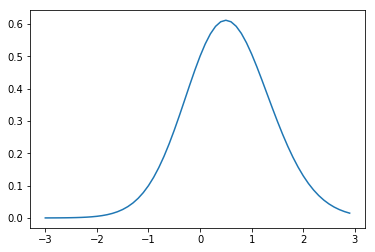

In [12]:
import matplotlib.pyplot as plt

t = np.arange(-3.0, 3.0, 0.1)

plt.plot(t, np.exp(-t**2/2)*(1/(1+np.exp(-1.62434536*t))))

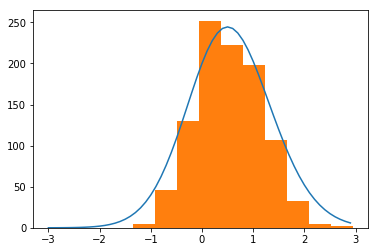

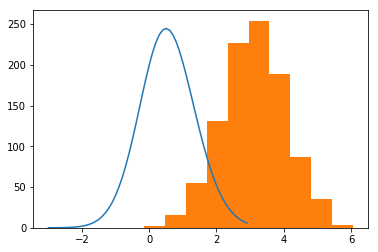

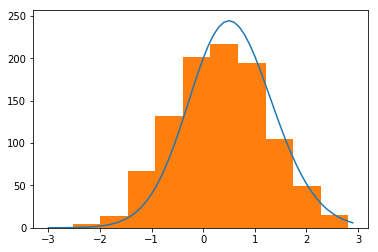

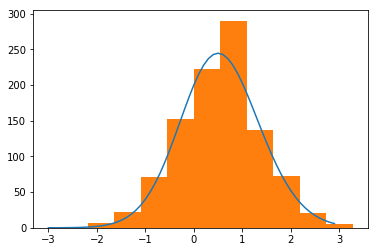

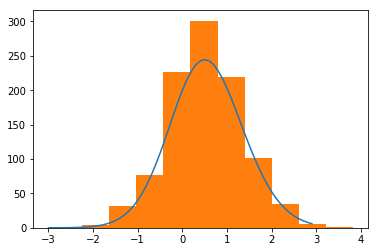

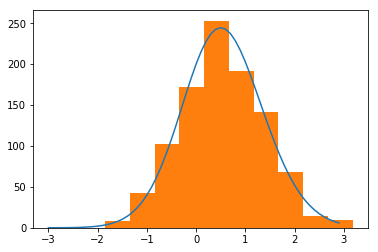

In [13]:
for i in range(6):
    plt.plot(t,400*np.exp(-t**2/2)*(1/(1+np.exp(-1.62434536*t))))
    plt.hist(samples_list[i,:,0])
    plt.show()

In [34]:
basic = make_mala_agent()
normal_samples = redraw_samples(basic,1000)

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 438
Drawing sample 439
Drawing sample 440
Drawing sample 441
Drawing sample 442
Drawing sample 443
Drawing sample 444
Drawing sample 445
Drawing sample 446
Drawing sample 447
Drawing sample 448
Drawing sample 449
Drawing sample 450
Drawing sample 451
Drawing sample 452
Drawing sample 453
Drawing sample 454
Drawing sample 455
Drawing sample 456
Drawing sample 457
Drawing sample 458
Drawing sample 459
Drawing sample 460
Drawing sample 461
Drawing sample 462
Drawing sample 463
Drawing sample 464
Drawing sample 465
Drawing sample 466
Drawing sample 467
Drawing sample 468
Drawing sample 469
Drawing sample 470
Drawing sample 471
Drawing sample 472
Drawing sample 473
Drawing sample 474
Drawing sample 475
Drawing sample 476
Drawing sample 477
Drawing sample 478
Drawing sample 479
Drawing sample 480
Drawing sample 481
Drawing sample 482
Drawing sample 483
Drawing sample 484
Drawing sample 485
Drawing sample 486
Drawing sample 487
Drawing sample 488
Drawing sample 489
Drawing samp

Drawing sample 870
Drawing sample 871
Drawing sample 872
Drawing sample 873
Drawing sample 874
Drawing sample 875
Drawing sample 876
Drawing sample 877
Drawing sample 878
Drawing sample 879
Drawing sample 880
Drawing sample 881
Drawing sample 882
Drawing sample 883
Drawing sample 884
Drawing sample 885
Drawing sample 886
Drawing sample 887
Drawing sample 888
Drawing sample 889
Drawing sample 890
Drawing sample 891
Drawing sample 892
Drawing sample 893
Drawing sample 894
Drawing sample 895
Drawing sample 896
Drawing sample 897
Drawing sample 898
Drawing sample 899
Drawing sample 900
Drawing sample 901
Drawing sample 902
Drawing sample 903
Drawing sample 904
Drawing sample 905
Drawing sample 906
Drawing sample 907
Drawing sample 908
Drawing sample 909
Drawing sample 910
Drawing sample 911
Drawing sample 912
Drawing sample 913
Drawing sample 914
Drawing sample 915
Drawing sample 916
Drawing sample 917
Drawing sample 918
Drawing sample 919
Drawing sample 920
Drawing sample 921
Drawing samp

(array([  8.,  31.,  75., 150., 252., 203., 152.,  83.,  36.,  10.]),
 array([-1.721301  , -1.37431393, -1.02732685, -0.68033978, -0.33335271,
         0.01363436,  0.36062143,  0.7076085 ,  1.05459557,  1.40158264,
         1.74856972]),
 <a list of 10 Patch objects>)

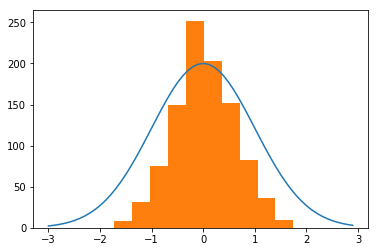

In [38]:
plt.plot(t,200*np.exp(-t**2/2))
plt.hist(normal_samples[:,0])

In [16]:
def mala_normal(x=0,step_size=0.01,num_steps=1000, verbosity=0):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        z = x - step_size*x + scaled_noise
        #scaled_noise
        p = np.exp(-(z**2)/2+(x**2)/2+((x-z-step_size*z)**2)/(4*step_size)-(noise**2)/2)
        x = z if np.random.random()<p else x
        printv((x,p),verbosity,1)
    return x

def mala_normal_lf(x=0,step_size=0.01,num_steps=1000, verbosity=0):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        z = x - step_size*x + scaled_noise
        def H(x,v):
            return 0.5*x**2 + 0.5*v**2
        v = noise - np.sqrt(step_size/2)*x-np.sqrt(step_size/2)*z
        #scaled_noise
        p = math.exp(H(z,v) - H(x,noise))
        x = z if np.random.random()<p else x
        printv((x,p),verbosity,1)
    return x

"""def mala_normal2(x=0,step_size=0.01,num_steps=1000):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        scale = 0.5
        z = x - scale*step_size*x + scaled_noise
        #scaled_noise
        p = np.exp(-z**2*0.5*scale+x**2*0.5*scale+((x-z+scale*step_size*z)**2)/(4*step_size)-(noise)**2/2)
        x = z if np.random.random()<p else x
    return x"""

'def mala_normal2(x=0,step_size=0.01,num_steps=1000):\n    for t in range(num_steps):\n        noise = np.random.randn()\n        scaled_noise = np.sqrt(2*step_size) * noise\n        scale = 0.5\n        z = x - scale*step_size*x + scaled_noise\n        #scaled_noise\n        p = np.exp(-z**2*0.5*scale+x**2*0.5*scale+((x-z+scale*step_size*z)**2)/(4*step_size)-(noise)**2/2)\n        x = z if np.random.random()<p else x\n    return x'

In [19]:
#normal_samples2 = [mala_normal(step_size=0.001,num_steps=100000) for t in range(100)]
normal_samples2 = [mala_normal(x=0,step_size=0.1,num_steps=2000) for t in range(1000)]

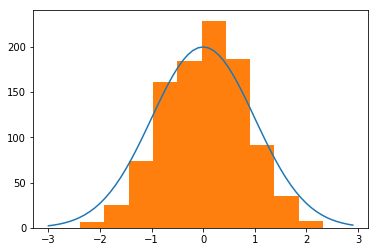

0.63342718233975

In [21]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,200*np.exp(-t**2/2))
#plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples2)
plt.show()
np.sum(np.power(normal_samples2,2))/1000

In [22]:
np.mean(np.square(normal_samples2))

0.63342718233975

In [17]:
normal_samples_lf = [mala_normal_lf(x=0,step_size=0.1,num_steps=4000) for t in range(2000)]

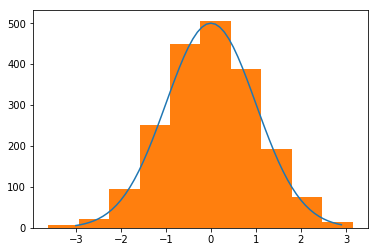

2.1677699022724632

In [18]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,500*np.exp(-t**2/2))
#plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples_lf)
plt.show()
np.sum(np.power(normal_samples_lf,2))/1000

In [19]:
np.mean(np.square(normal_samples_lf))

1.0838849511362316

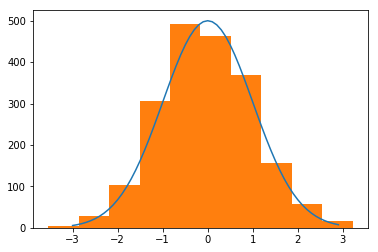

1.0714087822283422

In [20]:
normal_samples_lf8000 = [mala_normal_lf(x=0,step_size=0.1,num_steps=8000) for t in range(2000)]
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,500*np.exp(-t**2/2))
#plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples_lf8000)
plt.show()
np.mean(np.square(normal_samples_lf8000))

In [78]:
normal_samples22 = [mala_normal2(x=0,step_size=0.01,num_steps=1000) for t in range(1000)]

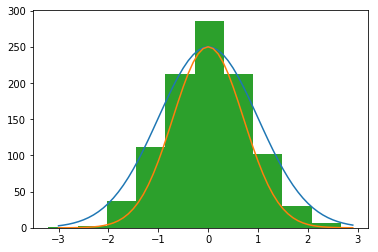

(-3.2029974213616397, 2.6630162674680995)

In [81]:

t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,250*np.exp(-t**2/2))
plt.plot(t,250*np.exp(-t**2))
plt.hist(normal_samples22)
plt.show()
(min(normal_samples22), max(normal_samples22))

In [ ]:
normal_samples3 = [np.random.randn() for t in range(500)]
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,100*np.exp(-t**2/2))
plt.hist(normal_samples3)
plt.show()

(array([100.,  96., 104.,  97.,  95.,  99., 101.,  95.,  97., 116.]),
 array([0.001597  , 0.10132025, 0.2010435 , 0.30076676, 0.40049001,
        0.50021326, 0.59993651, 0.69965976, 0.79938301, 0.89910626,
        0.99882951]),
 <a list of 10 Patch objects>)

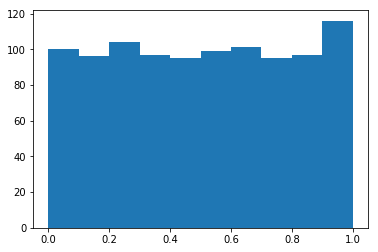

In [38]:
unif_samples = [np.random.random() for t in range(1000)]
plt.hist(unif_samples)

In [51]:
def mala_test2(x=0,step_size=0.01,num_steps=1000):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        z = x - step_size*1.5*np.sqrt(np.abs(x))*np.sign(x) + scaled_noise
        #scaled_noise
        p = np.exp(-np.abs(z)**1.5+np.abs(x)**1.5+(x-z+step_size*1.5*np.sqrt(np.abs(z))*np.sign(z))**2/(4*step_size)-(noise)**2/2)
        x = z if np.random.random()<p else x
    return x

In [54]:
test2 = [mala_test2(x=0,step_size=0.01,num_steps=1000) for t in range(1000)]

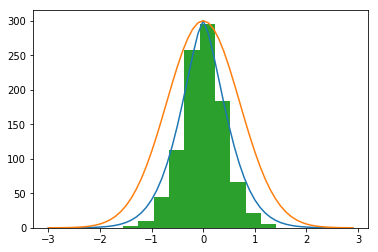

In [58]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,300*np.exp(-np.abs(t)**1.5*2))
plt.plot(t,300*np.exp(-t**2))
plt.hist(test2)
plt.show()

In [91]:
mala_normal(x=0,step_size=0.1,num_steps=1000, verbosity=1)

(0.7866569423454293, 0.5469715896909595)
(0.7866569423454293, 0.3485376477350185)
(0.6755399321422417, 1.1716500698932582)
(0.9367384124981939, 0.6632544761379131)
(1.3129456949349048, 0.43815223706456224)
(1.3756446464266823, 0.8484386504059658)
(1.1431717653916718, 1.769890349713403)
(1.1431717653916718, 0.1284698329610172)
(1.2018237510146215, 0.8745024549804663)
(1.2018237510146215, 0.22189592087947496)
(1.2018237510146215, 0.15733630271403842)
(0.38810531804191073, 3.530398400277201)
(0.2482580094058891, 1.0906445548450296)
(0.2482580094058891, 0.35821159958955723)
(-0.07921801263648007, 1.0554557161167928)
(-0.20643387547834285, 0.9651893636490018)
(-0.3372137882238937, 0.933027373653171)
(-0.3372137882238937, 0.6458919778859128)
(-0.35472021036097395, 0.9882590132288406)
(-0.7242349828287031, 0.6779222754134115)
(-0.29272789155450185, 1.5339652117555784)
(0.313730362512889, 0.9876580999348794)
(0.313730362512889, 0.6939408159731613)
(-0.258145976887076, 1.031477984492912)
(-0.28

1.1429397178444807

In [6]:
def langevin_normal(x=0,step_size=0.01,num_steps=1000, verbosity=0):
    for t in range(num_steps):
        noise = np.random.randn()
        scaled_noise = np.sqrt(2*step_size) * noise
        x = x - step_size*x + scaled_noise
        #scaled_noise
        #p = np.exp(-(z**2)/2+(x**2)/2+((x-z+step_size*z)**2)/(4*step_size)-(noise**2)/2)
        #x = z if np.random.random()<p else x
        printv(x,verbosity,1)
    return x

In [ ]:
lgv_samples = [langevin_normal(x=0,step_size=0.01,
                               num_steps=1000, verbosity=0) for _ in range(1000)]


(array([  5.,  22.,  98., 201., 267., 226., 126.,  37.,  15.,   3.]),
 array([-3.25451389, -2.55872319, -1.86293249, -1.16714179, -0.47135109,
         0.22443961,  0.92023031,  1.61602101,  2.31181172,  3.00760242,
         3.70339312]),
 <a list of 10 Patch objects>)

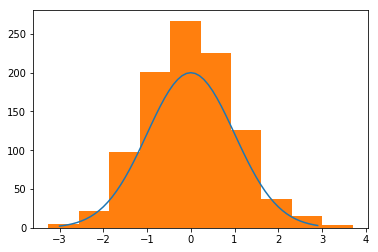

In [10]:
t = np.arange(-3.0, 3.0, 0.1)
plt.plot(t,200*np.exp(-t**2/2))
plt.hist(lgv_samples)